# Visualize MERIS TSM


In [22]:
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

In [23]:
# Load stacked NetCDF
stack_path = "../../MERIS_downloads/stacked_tsm.nc"  # or "stacked_tsm_clipped.nc"
ds = xr.open_dataset(stack_path)
tsm = ds["TSM"]

# Summary of dimensions and time range
print("Dataset summary:")
print(tsm)

Dataset summary:
<xarray.DataArray 'TSM' (time: 7, lat: 7408, lon: 7408)> Size: 3GB
[384149248 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 56B 2010-04-01T18:52:04 ... 2010-04-04T19:...
  * lat      (lat) float64 59kB 30.0 30.0 30.01 30.01 ... 49.99 49.99 50.0 50.0
  * lon      (lon) float64 59kB -130.0 -130.0 -130.0 ... -110.0 -110.0 -110.0


In [ ]:
# Set up 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
axs = axs.flatten()

vmin = ds.TSM.min().item()
vmax = ds.TSM.max().item()

for i in range(4):
    ax = axs[i]
    swath = ds.isel(time=i)
    sc = swath.TSM.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )
    ax.set_title(f"Swath {i+1}: {str(swath.time.values)[:10]}")
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add one shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
fig.colorbar(sc, cax=cbar_ax, label="TSM (g/m³)")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


/var/folders/s4/fgp_82s164bdthhpn1lw4tb40000gq/T/ipykernel_54015/2033972382.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


In [21]:
print(ds.TSM.min(), ds.TSM.max())
print(ds.TSM.attrs)  # Any _FillValue or nodata attributes?

<xarray.DataArray 'TSM' ()> Size: 8B
array(-1.26806022) <xarray.DataArray 'TSM' ()> Size: 8B
array(1.98425198)
{}


## Look at the corresponding raw fle

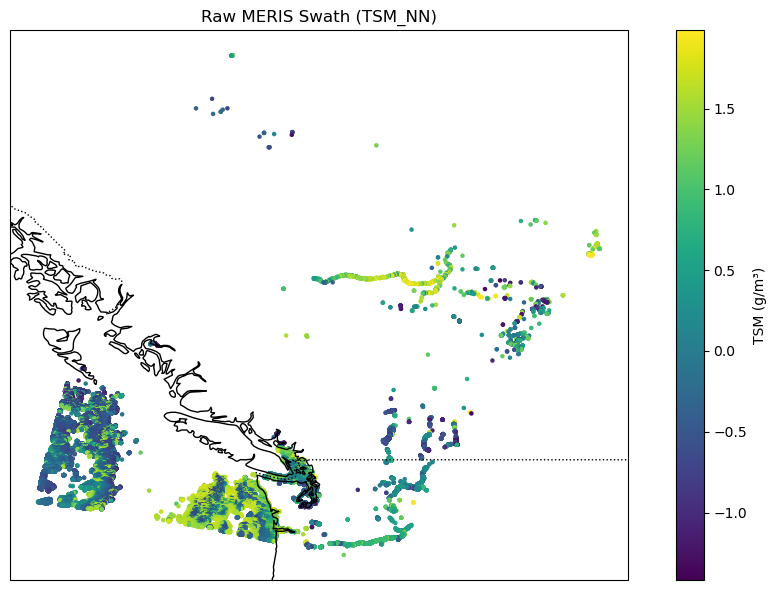

In [6]:
## Look at the corresponding raw fle
# Load raw files
tsm = xr.open_dataset("../../MERIS_downloads/processed/EN1_MDSI_MER_FRS_2P_20100401T185204_20100401T190059_042280_0142_20180216T184111_0100/tsm_nn.nc")["TSM_NN"].values
lat = xr.open_dataset("../../MERIS_downloads/processed/EN1_MDSI_MER_FRS_2P_20100401T185204_20100401T190059_042280_0142_20180216T184111_0100/geo_coordinates.nc")["latitude"].values
lon = xr.open_dataset("../../MERIS_downloads/processed/EN1_MDSI_MER_FRS_2P_20100401T185204_20100401T190059_042280_0142_20180216T184111_0100/geo_coordinates.nc")["longitude"].values

# Mask invalids
mask = ~np.isnan(tsm)
lat_valid = lat[mask]
lon_valid = lon[mask]
tsm_valid = tsm[mask]

# Plot scatter
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
sc = ax.scatter(lon_valid, lat_valid, c=tsm_valid, cmap="viridis", s=5, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
plt.colorbar(sc, label="TSM (g/m³)")
plt.title("Raw MERIS Swath (TSM_NN)")
plt.tight_layout()
plt.show()


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

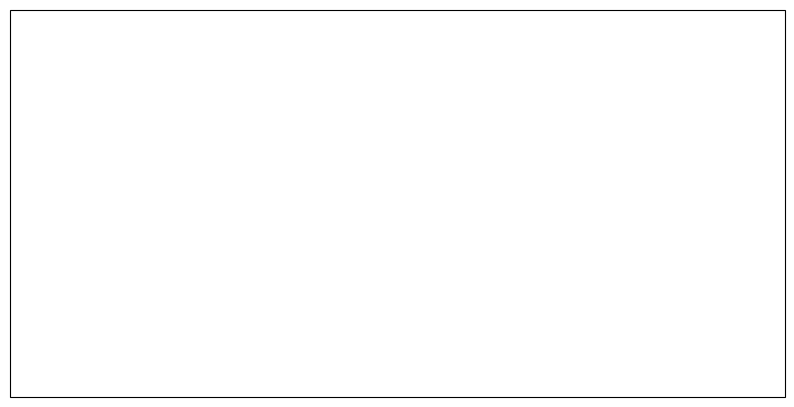

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load raw files
folder = "../../MERIS_downloads/processed/EN1_MDSI_MER_FRS_2P_20100401T185204_20100401T190059_042280_0142_20180216T184111_0100"
tsm = xr.open_dataset(f"{folder}/tsm_nn.nc")["TSM_NN"].values
lat = xr.open_dataset(f"{folder}/geo_coordinates.nc")["latitude"].values
lon = xr.open_dataset(f"{folder}/geo_coordinates.nc")["longitude"].values

# Only drop outer fully-NaN rows/cols
valid = ~np.isnan(tsm) & ~np.isnan(lat) & ~np.isnan(lon)
valid_rows = np.where(np.any(valid, axis=1))[0]
valid_cols = np.where(np.any(valid, axis=0))[0]

row_start, row_end = valid_rows[0], valid_rows[-1] + 1
col_start, col_end = valid_cols[0], valid_cols[-1] + 1

tsm_trim = tsm[row_start:row_end, col_start:col_end]
lat_trim = lat[row_start:row_end, col_start:col_end]
lon_trim = lon[row_start:row_end, col_start:col_end]

# Now plot using pcolormesh
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
pc = ax.pcolormesh(
    lon_trim,
    lat_trim,
    np.ma.masked_invalid(tsm_trim),
    cmap="viridis",
    shading="auto",
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
plt.colorbar(pc, label="TSM (g/m³)")
plt.title("Raw MERIS Swath (Preserved Grid Structure)")
plt.tight_layout()
plt.show()
